# Covariance matrix for binned excess surface density

In [24]:
import matplotlib.pyplot as plt
import sys
import numpy as np
from astropy.table import Table, QTable, hstack, vstack, join
import clmm
import clmm.dataops as da
from clmm.support import mock_data as mock
from clmm import Cosmology
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

## Excess surface density profile
### Background galaxy catalog

In [25]:
cosmo = cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15 # M200,m [Msun]
cluster_z = 0.3
src_z = 0.8
concentration = 4
ngals = 10000
cluster_ra = 20.0
cluster_dec = 30.0

In [26]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, 
                                          cosmo, src_z, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec,
                                          shapenoise=.3,)

In [27]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)

In [28]:
ra_l = gc_object.ra
dec_l = gc_object.dec
z = gc_object.z
e1 = gc_object.galcat['e1']
e2 = gc_object.galcat['e2']
ra_s = gc_object.galcat['ra']
dec_s = gc_object.galcat['dec']
z_s = gc_object.galcat['z']

In [29]:
theta, g_t, g_x = da.compute_tangential_and_cross_components(ra_l, dec_l, ra_s, dec_s, e1, e2, 'flat', True, cosmo,z, z_s)

In [30]:
theta, phi = da._compute_lensing_angles_flatsky(ra_l, dec_l, ra_s, dec_s)

### Binned excess surface density profile

In [31]:
bin_edges = da.make_bins(0.01, 3.7, 10)
prf = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=bin_edges, cosmo=cosmo, z_lens=z, include_empty_bins=False)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/clmm-1.1.2-py3.7.egg/clmm/utils.py:68: RuntimeWarning: invalid value encountered in sqrt


## Covariance

### Jackknife resampling
We use the jackknife resampling:
- we divide in $N_{JK}$ equal sized areas arround the cluster center (based on regular polar angle separation)
- we remove one Jackknife region at a time, and estimate the new shear profile
- After doing it for the $N_{JK}$ regions, we compute 
$$
C_{ij} = \frac{N_{JK}-1}{N_{JK}}\sum_{k=1}^{N_{JK}}(\Delta\Sigma_k(R_i)-\widehat{\Delta\Sigma(R_i)})(\Delta\Sigma_k(R_j)-\widehat{\Delta\Sigma(R_j)})
$$
where 
$$
\widehat{\Delta\Sigma(R_i)} = \frac{1}{N_{JK}}\sum_{k=1}^{N_{JK}}\Delta\Sigma_k(R_i)
$$


In [32]:
def jackknife_covariance(g, theta, phi, bin_edges, n_jk = 1):
    r"""
    compute the jackknife covariance matrix for individual cluster
    g: array
        tangential /cross ellipticities (or sigma_c * et/x for excess surface density)
    theta: array
        galaxy angular separation from cluster center
    phi: array
        galaxy polar angles
    bin_edges: array
        bin edges for radial profile
    n_jk: int
        number of jackknife region
    """
    phi_corner = np.linspace(-np.pi, np.pi, n_jk + 1)
    phi_bin = [[phi_corner[i], phi_corner[i+1]] for i in range(len(phi_corner)-1)]
    g_jackk=np.zeros([n_jk, len(bin_edges)-1])
    for i,phi_ in enumerate(phi_bin):
        mask_phi = np.invert((phi_[0]<phi)*(phi_[1]>=phi))
        prf_jackk=da.make_radial_profile([g[mask_phi]], 
                                     theta[mask_phi], "radians", "Mpc", 
                                     bins=bin_edges, cosmo=cosmo, 
                                     z_lens=z, include_empty_bins=True)
        g_jackk[i,:]=np.array(prf_jackk['p_0'])
    coeff = (n_jk-1)/n_jk
    cov = coeff*(n_jk-1)*np.cov(g_jackk.T, bias=False)
    return cov

In [33]:
covt=jackknife_covariance(g_t, theta, phi, bin_edges, n_jk = 200)

### plot covariance

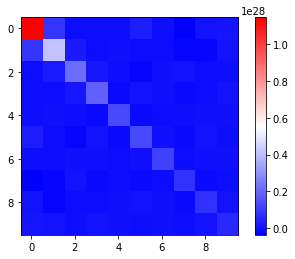

In [34]:
plt.imshow(covt, cmap='bwr')
plt.colorbar()

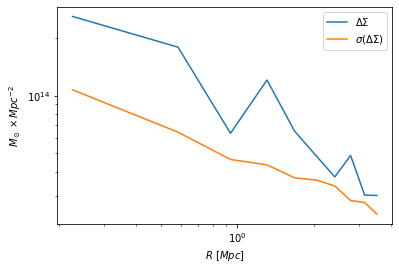

In [35]:
plt.loglog(prf['radius'],prf['p_0'], label=r'$\Delta\Sigma$')
plt.loglog(prf['radius'],covt.diagonal()**.5, label=r'$\sigma(\Delta\Sigma)$')
plt.ylabel(r'$M_\odot\times Mpc^{-2}$')
plt.xlabel(r'$R\ [Mpc]$')
plt.legend()
plt.show()

### plot correlation

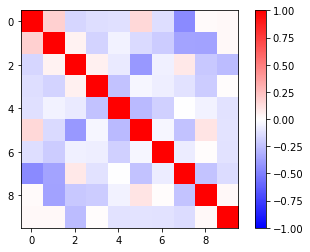

In [36]:
plt.imshow(np.corrcoef(covt), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()